In [30]:
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [9]:
os.getcwd()

'/home/compu/CNN-DogBreed'

In [18]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))



87916544/87910968 [==============================] - 108s 1us/step


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(122, activation='softmax'))

In [22]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수 :', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 : 192
conv_base를 동결한 후 훈련되는 가중치의 수 : 4


In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(224, 224),
                                                        batch_size=20,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='categorical')

Found 6411 images belonging to 122 classes.
Found 2137 images belonging to 122 classes.
Found 2137 images belonging to 122 classes.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=320,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=160,
                              verbose=0)

In [25]:
callbacks = [EarlyStopping(monitor='val_acc',
                           patience=10),
             ModelCheckpoint(filepath='model_best.h5',
                             monitor='val_loss',
                             save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=10)]

In [ ]:
'''
1. 인센셥 모델의 가중치를 동결한 후 분류기 학습
2. (원래 계획) 인셉션 모델의 일부 상위층의 동결을 해제한 다음 분류기와 같이 재학습
3. (변경된 계획)Short connection 등으로 인해 구분이 불분명해져서 전체 모델의 동결을 해제한 다음 분류기와 같이 재학습
'''
# set_trainable = False
# for layer in conv_base.layer:
#     if layer.name == 'block5_con1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

conv_base.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(train_generator,
                              steps_per_epoch=320,
                              epochs=1000,
                              validation_data=validation_generator,
                              validation_steps=160,
                              callbacks=callbacks,
                              verbose=0)

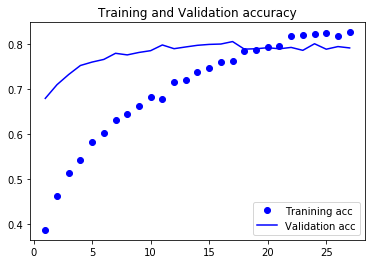

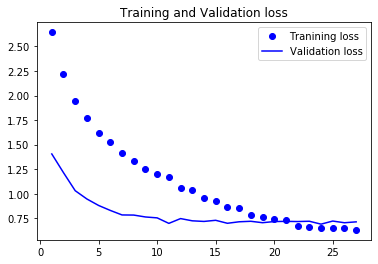

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Tranining acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Tranining loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [29]:
MobileNet = models.load_model('model_best.h5')
scores = MobileNet.evaluate_generator(test_generator, verbose=1)
scores

107/107 [==============================] - 57s 531ms/step


[0.7064271288173022, 0.7927000478544579]